# Task 3: Evaluate the model

In this notebook, I will evaluate the Faster R-CNN model which I had trained for 5 epochs in task 2.

As some of the paths are hardcoded and I have installed the dependencies separately, you will not be able to run all the cells in this notebook without some heavy adjustments.
Therefore, I request you to read along as the cell outputs will contain the necessary details.

I have already extracted the dataset into a folder in the same directory as this notebook, called data, and made some adjustments to the directory structure.

The labels have also been converted into COCO format in a previous task. Please refer to the additional notebook for task 2 where I do this by hand.

### The first step is to load our model weights. Below, I define a function to create a model that loads our weights from a previous checkpoint, sets it to eval mode, loads it to the appropriate device and returns it.

In [77]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.datasets import CocoDetection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
import json


def setup_model(device):
    """
    Creates a fasterrcnn_resnet50_fpn model, loads it with 
    our saved weights, moves to device, and returns it.
    """
    # Load pretrained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights=None
    )

    # Replace the head to match number of classes
    num_classes = 11  # 10 classes + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Hardcoded path, sorry about that
    model.load_state_dict(torch.load("/home/ghosh/content/model_weights/faster_rcnn_weights_ep5.pth", map_location=device))

    # Move to device and set to eval
    model.to(device)
    # Since we are evaluating the model
    model.eval()
    return model

In [78]:
# This is a just-in-case if my directory gets deleted
# I also left it in because it explicitly maps the classes to ids

# Since we already know the classes from analysis time, let's just
# hardcode a dict to avoid counting everything again

# Disclaimer: I made a major error here and started counting at 0
# COCO style labels should always be 1-indexed. This will unfortunately affect eval
category_ids = {
    "traffic sign": 0,
    "traffic light": 1,
    "car": 2,
    "rider": 3,
    "motor": 4, # Motorcycle, haha
    "person": 5,
    "bus": 6,
    "truck": 7,
    "bike": 8,
    "train": 9
}

# Also, the image size is fixed for the whole dataset
IMAGE_WIDTH = 1280
IMAGE_HEIGHT = 720


In [79]:
def convert_bdd_to_coco(bdd_json, config):
    """
    Function to convert BDD100k labels to COCO
    """
    split, size = config # Not using size in this run
    print(f"Starting conversion for BDD {split} labels.")
    coco_json = {
        "type": "instances"
    }

    # Setting the categories attribute is straightforward,
    # since we have already assigned ids to each of the
    # 10 classes, and they have no supercategory
    coco_json["categories"] = [
        {
            "id": id,
            "name": category_name,
            "supercategory": "none"
        }
        for category_name, id in category_ids.items()
    ]

    # Now, we shall iterate over each of the objects of the
    # bdd_json, and populate the images and annotations keys
    # of our coco_json object
    coco_json["images"] = []
    coco_json["annotations"] = []
    for img_index, obj in enumerate(tqdm(bdd_json, total=len(bdd_json))):
        image_obj = {
            "file_name": obj["name"],
            "height": IMAGE_HEIGHT,
            "width": IMAGE_WIDTH,
            "id": img_index
        }
        image_has_valid_labels = False
        for label in obj["labels"]:
            if label["category"] in category_ids.keys():
                image_has_valid_labels = True
                x1 = label["box2d"]["x1"]
                y1 = label["box2d"]["y1"]
                x2 = label["box2d"]["x2"]
                y2 = label["box2d"]["y2"]
                # Build annotation object from extracted information
                annotation = {
                    "id": label["id"],
                    "image_id": img_index,
                    "category_id": category_ids[label["category"]],
                    "bbox": [x1, y1, x2 - x1, y2 - y1],
                    "area": float((x2 - x1) * (y2 - y1)),
                    "iscrowd": 0,
                    "ignore": 0,
                    "segmentation": [x1, y1, x1, y2, x2, y2, x2, y1]
                }
                coco_json["annotations"].append(annotation)
        if image_has_valid_labels:
            coco_json["images"].append(image_obj)

    # Finally, write the coco_json to a label file
    with open(f"/home/ghosh/content/data/labels_coco/{split}.json", "w") as f:
        json.dump(coco_json, f)
    print(f"Finished conversion for BDD {split} labels.")

In [80]:
configs = [("train", 7000), ("val", 1000)]
for config in configs:
    # Read the bdd label json and generate coco labels
    bdd_json_path = f"/home/ghosh/content/data/labels_json/bdd100k_labels_images_{config[0]}.json"
    with open(bdd_json_path, "r") as f:
        bdd_json = json.load(f)
    convert_bdd_to_coco(bdd_json, config)

Starting conversion for BDD train labels.


100%|██████████| 69863/69863 [00:02<00:00, 25446.19it/s]


Finished conversion for BDD train labels.
Starting conversion for BDD val labels.


100%|██████████| 10000/10000 [00:00<00:00, 60877.71it/s]


Finished conversion for BDD val labels.


## Now that our labels have been converted, we can continue

In [81]:
# Create transform for dataloader
class COCOTransform:
    """
    Converts PIL to image tensor and sets up labels for training
    """
    def __call__(self, image, target):
        # Convert the PIL image to a tensor
        image_tensor = F.to_tensor(image)

        # Extract labels and correspondingbounding boxes
        labels = []
        bounding_boxes = []
        for obj in target:
            x, y, w, h = obj["bbox"]
            labels.append(obj["category_id"])
            bounding_boxes.append([x, y, x + w, y + h])

        # Return image as a tensor, and dict of labels and bounding boxes
        return image_tensor, {
            "boxes": torch.tensor(bounding_boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

### Function to create validation dataloader as before

In [82]:
def get_validation_dataloader(
        val_images_path,
        val_labels_coco_path,
        batch_size=4
):
    """
    Returns a dataloader for the validation set
    """
    val_dataset = CocoDetection(
        root=val_images_path,
        annFile=val_labels_coco_path,
        transforms=COCOTransform()
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=lambda batch: tuple(zip(*batch))
    )

    return val_loader

## Evaluation run, and Qualitative Analysis

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


100%|██████████| 2500/2500 [07:56<00:00,  5.24it/s]


Validation results: mAP = 0.2420 | mAP@0.5 = 0.4583 | mAP@0.75 = 0.2205
Class: traffic light


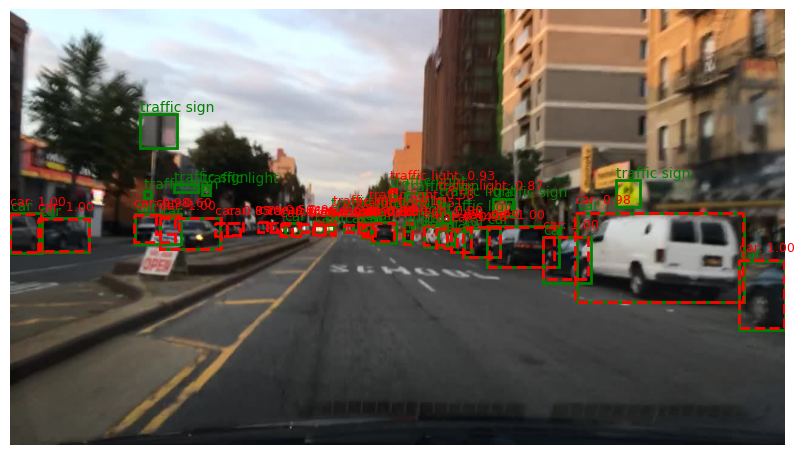

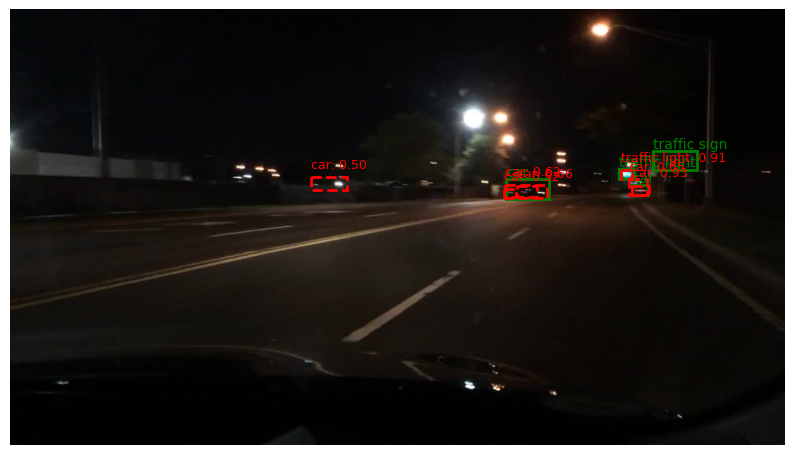

Class: car


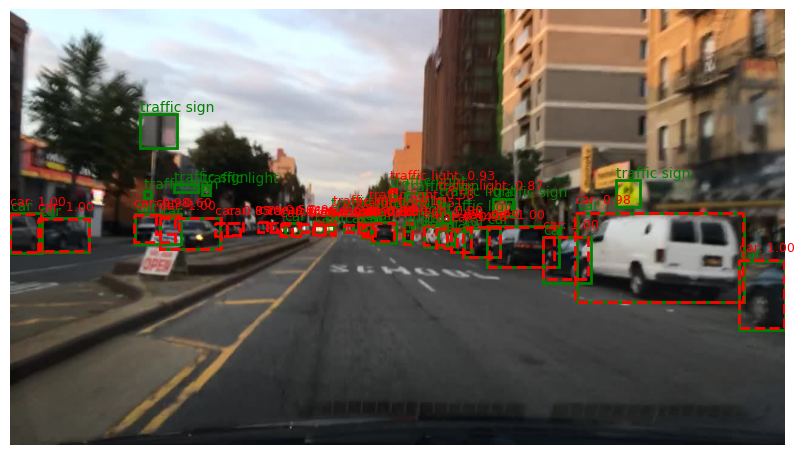

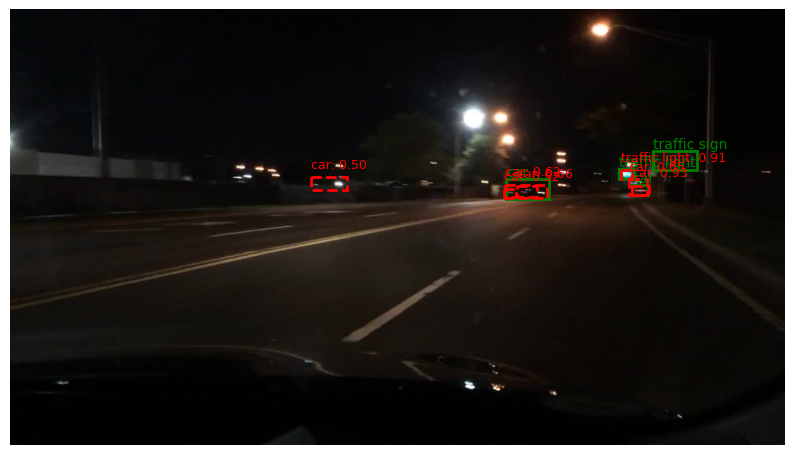

Class: rider


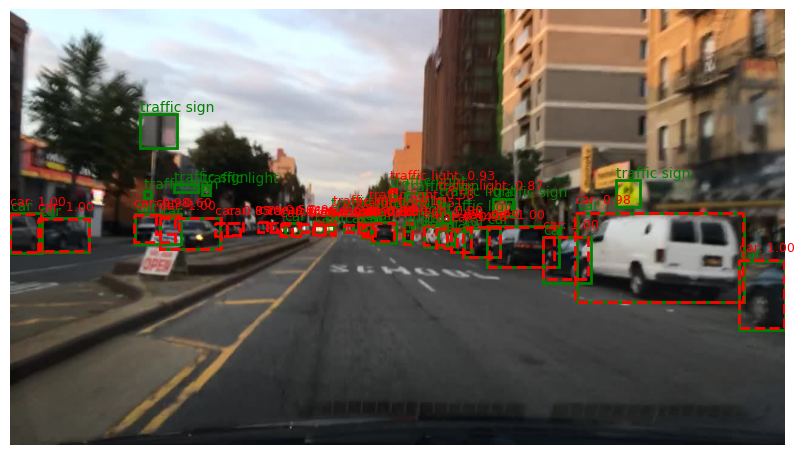

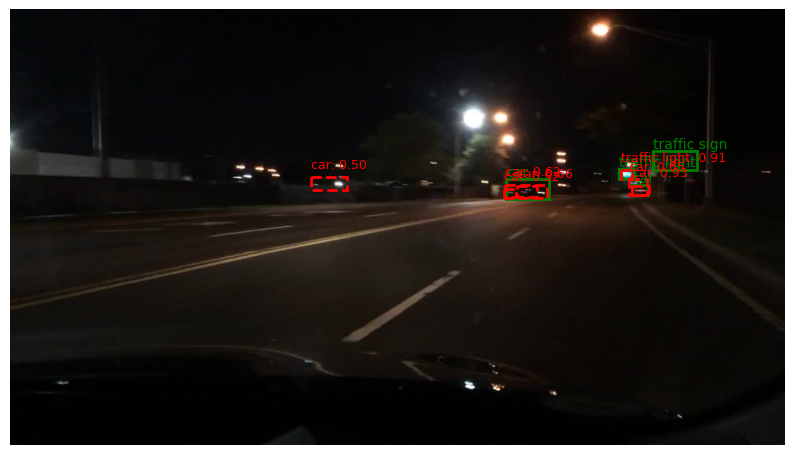

Class: motor


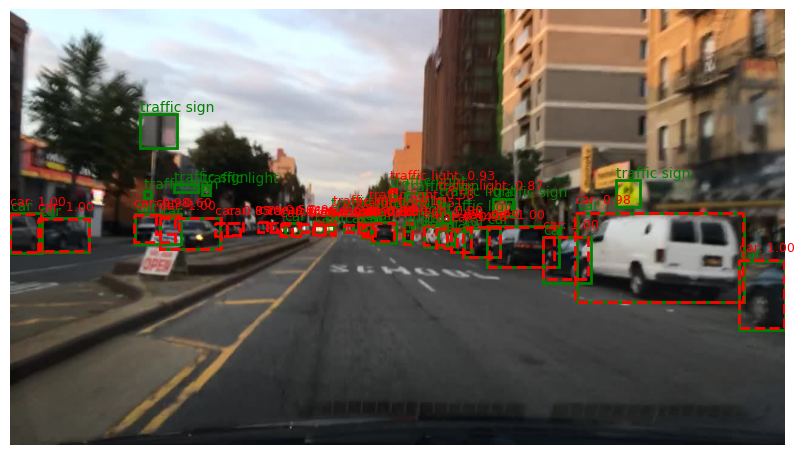

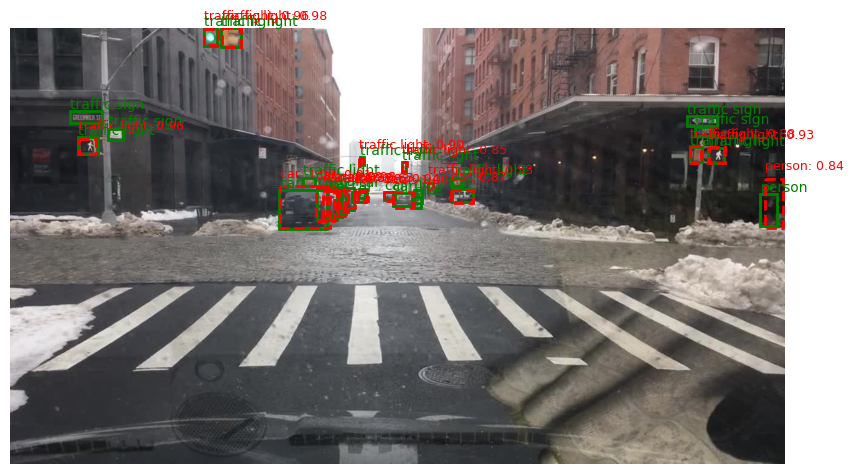

Class: person


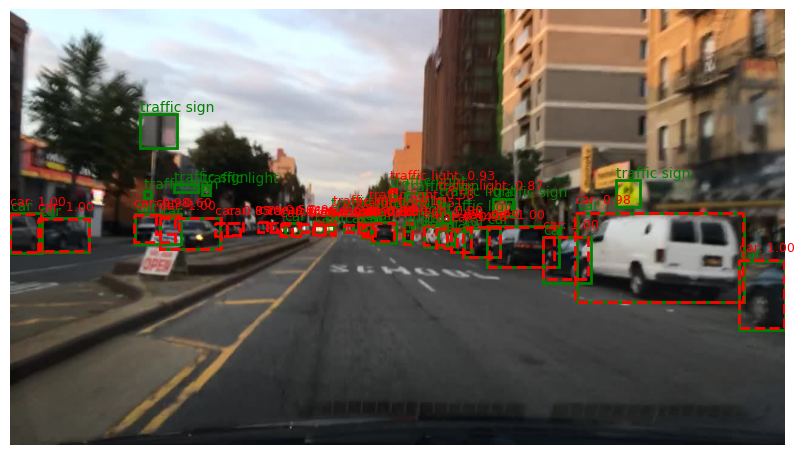

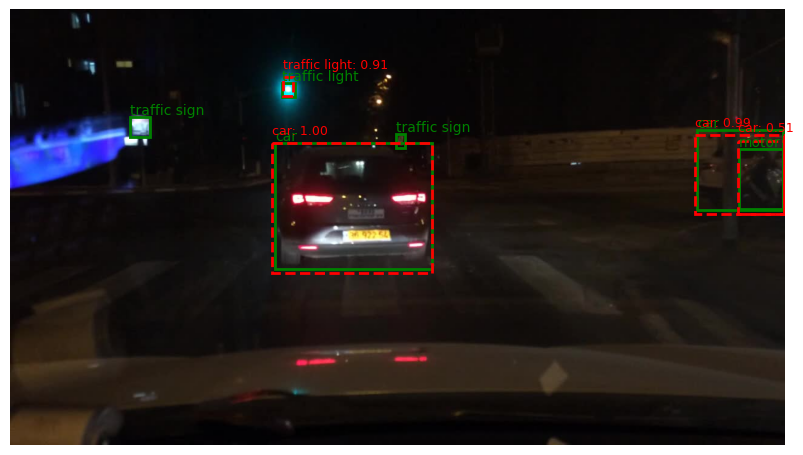

Class: bus


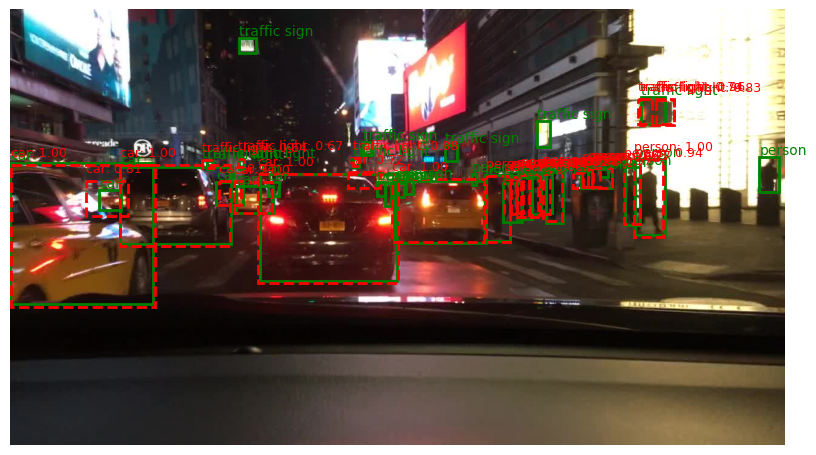

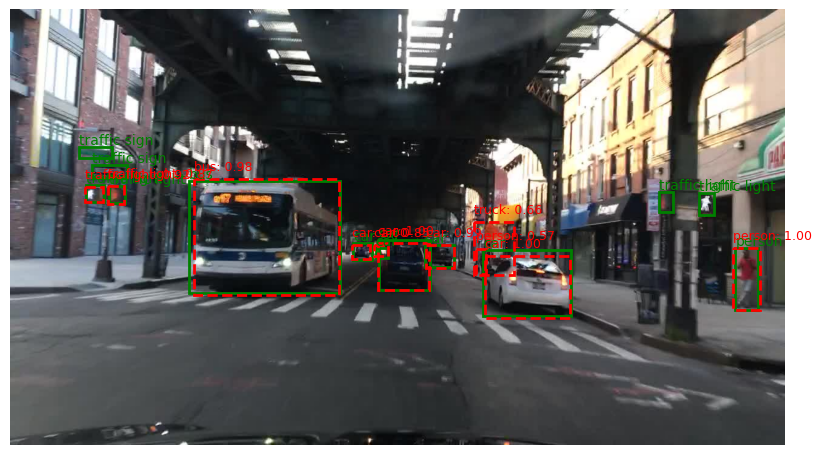

Class: truck


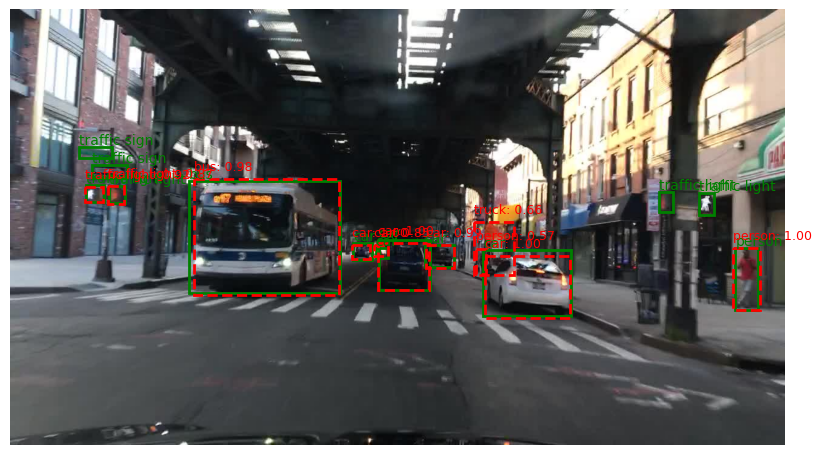

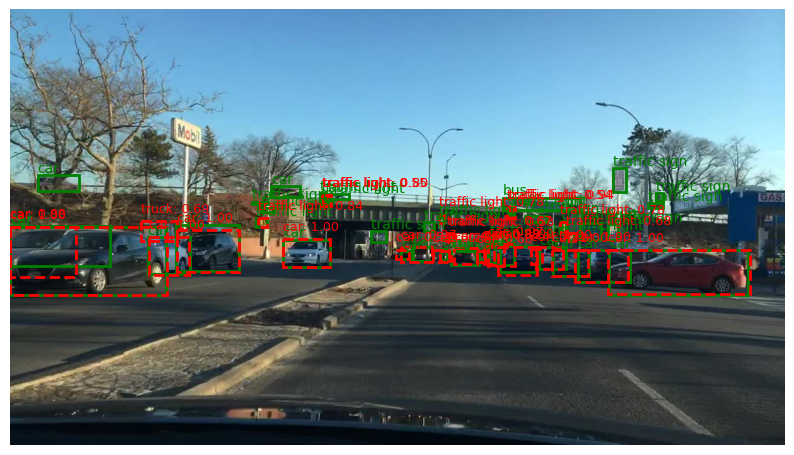

Class: bike


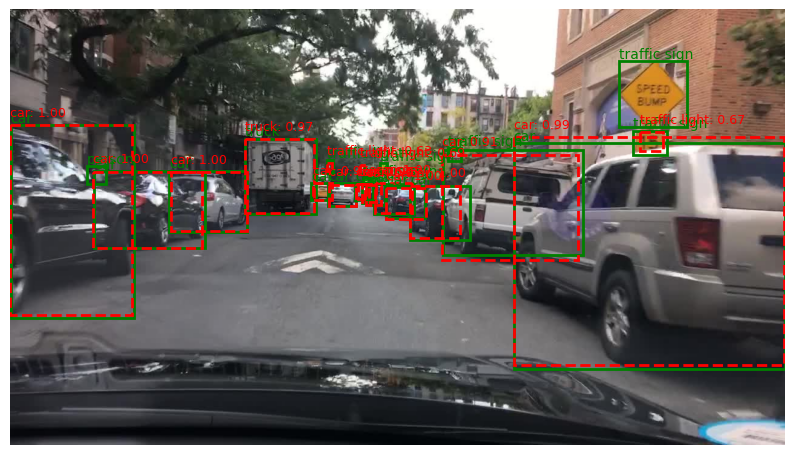

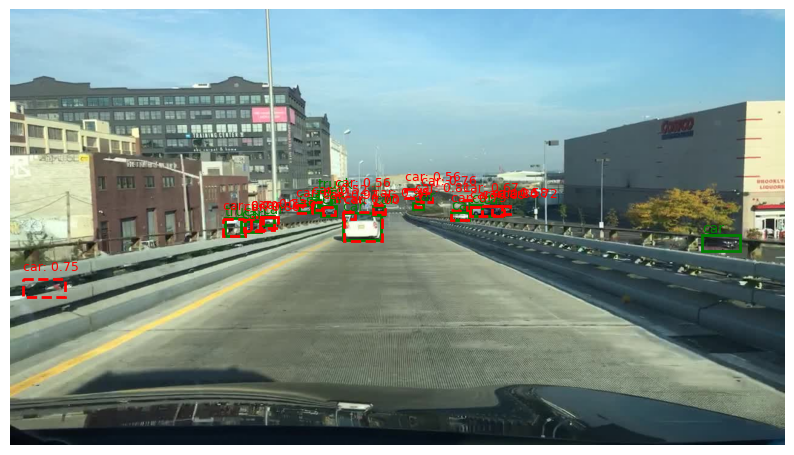

Class: train


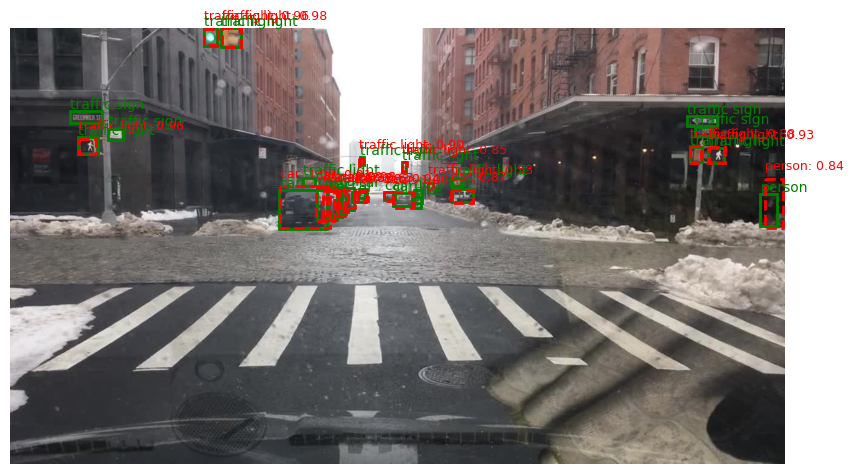

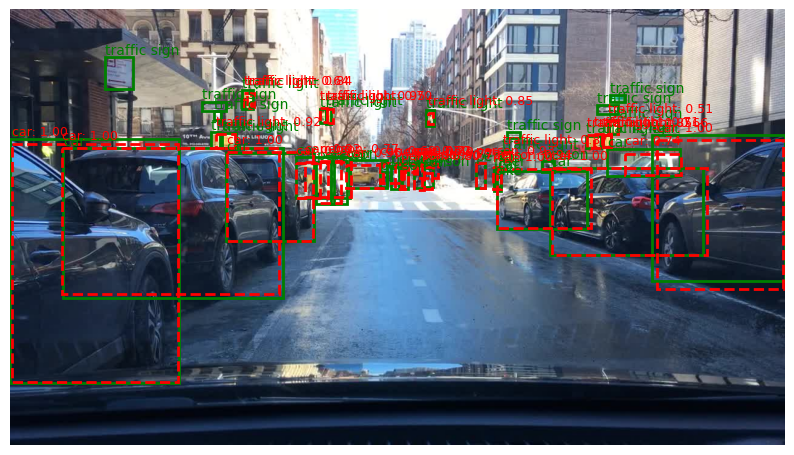

Class: traffic sign


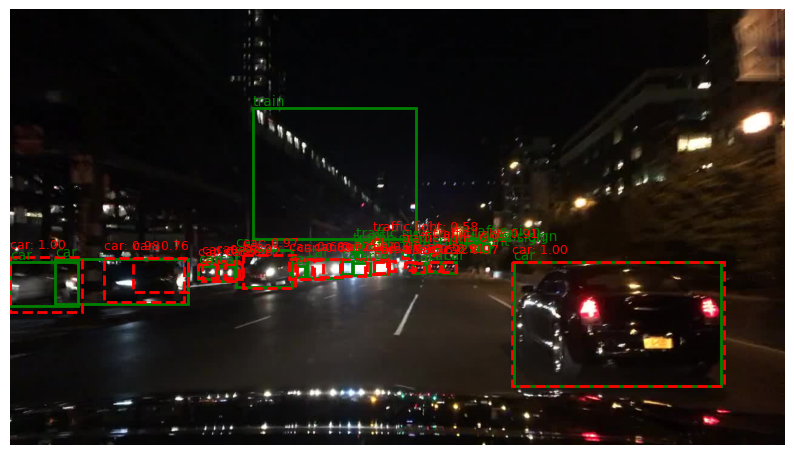

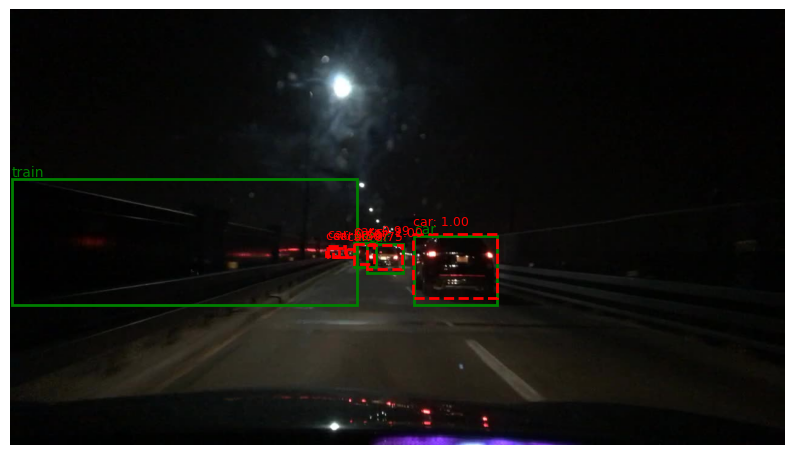

In [86]:
def evaluate_on_validation_set(model, val_loader, device, class_names, score_thresh=0.5):
    """
    Evaluate the model on the validation dataset, compute mAP, and plot 2 images per class.
    """
    metric = MeanAveragePrecision(class_metrics=True)

    # Keep track of 2 images per class
    images_per_class = {cls: [] for cls in range(len(class_names))}
    max_images = 2  # max images per class

    model.eval()
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            images = [image.to(device) for image in images]
            targets = [
                {key: value.to(device) for key, value in target.items()}
                for target in targets
            ]
            outputs = model(images)

            # Update metric
            metric.update(outputs, targets)

            # Collect images for qualitative analysis
            for img_tensor, target, pred in zip(images, targets, outputs):
                labels = target['labels'].cpu().tolist()
                for cls in set(labels):
                    if len(images_per_class[cls]) < max_images:
                        images_per_class[cls].append((img_tensor.cpu(), target, pred))

            # Stop collecting once we have enough images
            if all(len(v) >= max_images for v in images_per_class.values()):
                break

    # Compute metric
    result = metric.compute()
    output_string = (
        f"Validation results: mAP = {result['map'].item():.4f} | "
        f"mAP@0.5 = {result['map_50'].item():.4f} | "
        f"mAP@0.75 = {result['map_75'].item():.4f}"
    )
    print(output_string)

    # --- Qualitative plotting function ---
    def plot_image_with_boxes(img_tensor, target, pred, class_names, score_thresh=0.5):
        img = img_tensor.permute(1,2,0).numpy()  # CHW -> HWC
        fig, ax = plt.subplots(1, figsize=(10, 6))
        ax.imshow(img)

        # Ground truth boxes (green)
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, class_names[label-1], color='green', fontsize=10)  # label-1 if background=0

        # Predicted boxes (red dashed)
        for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
            if score < score_thresh:
                continue
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            ax.text(x1, y1-15, f"{class_names[label-1]}: {score:.2f}", color='red', fontsize=9)

        plt.axis('off')
        plt.show()

    # generate images with 
    for cls, img_list in images_per_class.items():
        print(f"Class: {class_names[cls]}")
        for img_tensor, target, pred in img_list:
            plot_image_with_boxes(img_tensor, target, pred, class_names, score_thresh)

    return result


class_names = [
    # Goofy 1-indexed problem 
    # Car has id 1, so it should be at index 1, otherwise qualitative evaluation problem   
    "traffic light", "car", "rider", "motor", "person", "bus", "truck", "bike", "train", "traffic sign"
]

# Assuming `model` is your trained Faster R-CNN, `val_loader` is your DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_images_path = "/home/ghosh/content/data/images/val"
val_labels_coco_path = "/home/ghosh/content/data/labels_coco/val.json"
model = setup_model(device)
val_loader = get_validation_dataloader(val_images_path, val_labels_coco_path)
# Call the evaluation function
result = evaluate_on_validation_set(model, val_loader, device, class_names, score_thresh=0.5)


The model actually seems to be doing quite well despite training with misaligned labels


## Quantitative Analysis

We can gather from the below plots that the model is somewhat confident about predicting large bounding boxes at 50% IoU


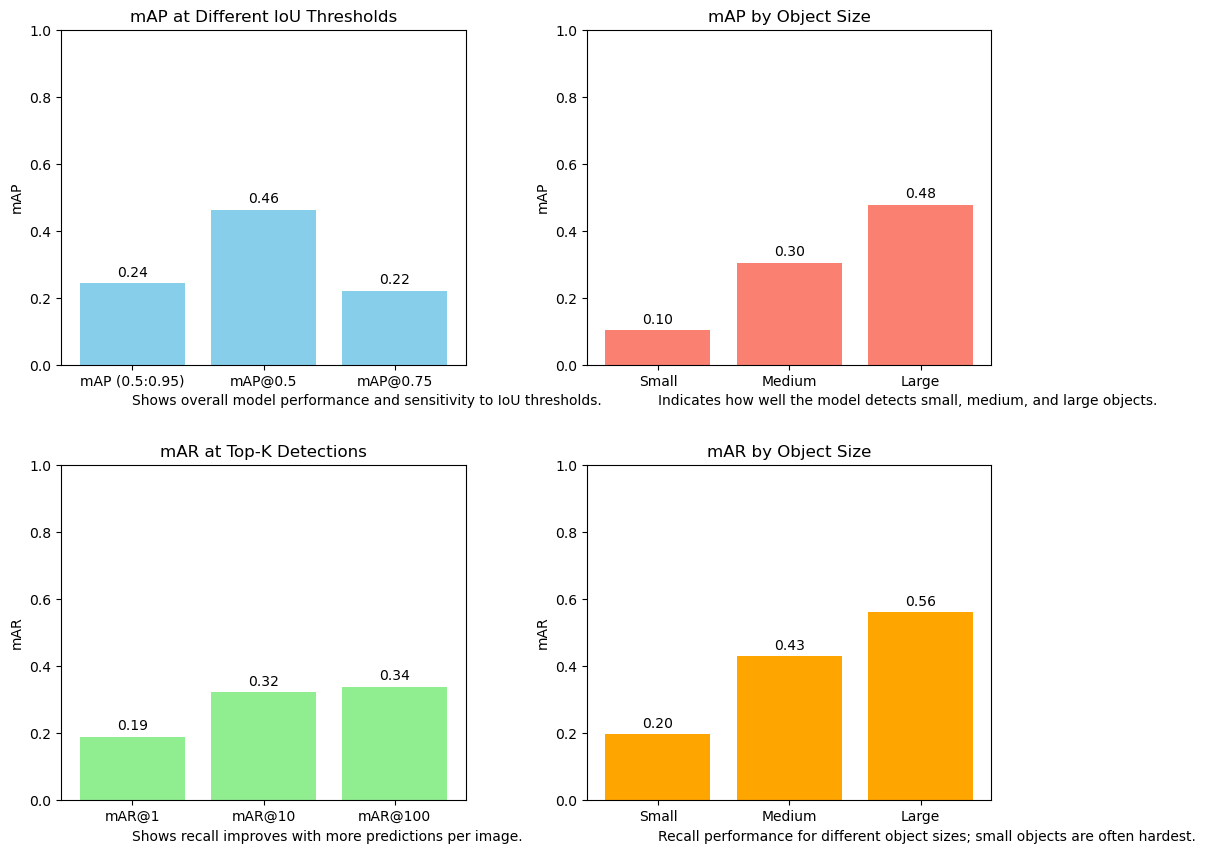

In [84]:
import matplotlib.pyplot as plt

# Extract data from result
map_values = [result['map'].item(), result['map_50'].item(), result['map_75'].item()]
map_labels = ["mAP (0.5:0.95)", "mAP@0.5", "mAP@0.75"]

size_map_values = [result['map_small'].item(), result['map_medium'].item(), result['map_large'].item()]
size_labels = ["Small", "Medium", "Large"]

mar_values = [result['mar_1'].item(), result['mar_10'].item(), result['mar_100'].item()]
mar_labels = ["mAR@1", "mAR@10", "mAR@100"]

size_mar_values = [result['mar_small'].item(), result['mar_medium'].item(), result['mar_large'].item()]
size_mar_labels = ["Small", "Medium", "Large"]

# Create 2x2 figure
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

axs[0,0].bar(map_labels, map_values, color='skyblue')
axs[0,0].set_ylim(0, 1)
axs[0,0].set_ylabel("mAP")
axs[0,0].set_title("mAP at Different IoU Thresholds")
for i, v in enumerate(map_values):
    axs[0,0].text(i, v + 0.02, f"{v:.2f}", ha='center')
axs[0,0].text(0, -0.12, "Shows overall model performance and sensitivity to IoU thresholds.", fontsize=10)

axs[0,1].bar(size_labels, size_map_values, color='salmon')
axs[0,1].set_ylim(0, 1)
axs[0,1].set_ylabel("mAP")
axs[0,1].set_title("mAP by Object Size")
for i, v in enumerate(size_map_values):
    axs[0,1].text(i, v + 0.02, f"{v:.2f}", ha='center')
axs[0,1].text(0, -0.12, "Indicates how well the model detects small, medium, and large objects.", fontsize=10)

axs[1,0].bar(mar_labels, mar_values, color='lightgreen')
axs[1,0].set_ylim(0, 1)
axs[1,0].set_ylabel("mAR")
axs[1,0].set_title("mAR at Top-K Detections")
for i, v in enumerate(mar_values):
    axs[1,0].text(i, v + 0.02, f"{v:.2f}", ha='center')
axs[1,0].text(0, -0.12, "Shows recall improves with more predictions per image.", fontsize=10)

axs[1,1].bar(size_mar_labels, size_mar_values, color='orange')
axs[1,1].set_ylim(0, 1)
axs[1,1].set_ylabel("mAR")
axs[1,1].set_title("mAR by Object Size")
for i, v in enumerate(size_mar_values):
    axs[1,1].text(i, v + 0.02, f"{v:.2f}", ha='center')
axs[1,1].text(0, -0.12, "Recall performance for different object sizes; small objects are often hardest.", fontsize=10)

plt.show()

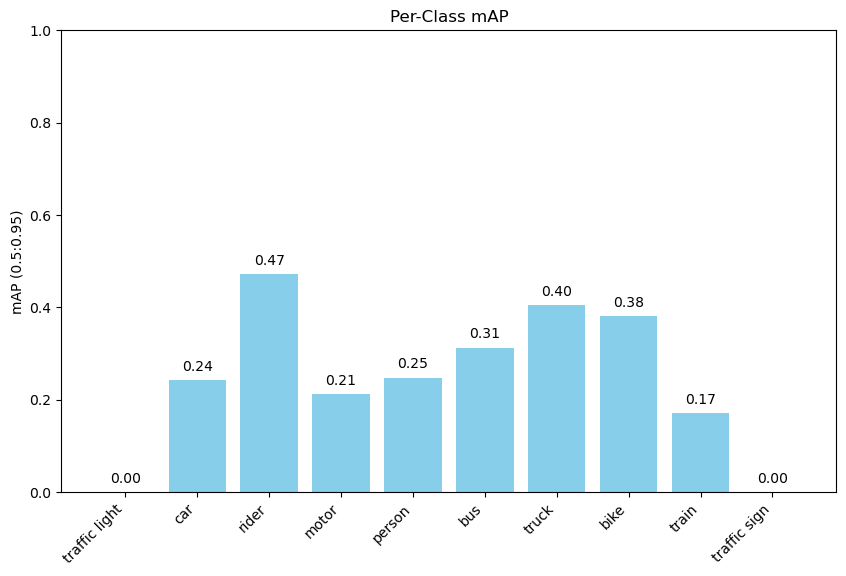

In [85]:
import matplotlib.pyplot as plt

def plot_per_class_map(result, class_names):
    """
    Plot per-class mAP (0.5:0.95) using result from MeanAveragePrecision.
    """
    if result['map_per_class'].numel() == 1 and result['map_per_class'].item() == -1:
        print("Per-class metrics were not computed. Make sure class_metrics=True.")
        return

    # Extract per-class metrics
    ap_per_class = result['map_per_class'].cpu().numpy()
    classes = result['classes'].cpu().numpy()

    plt.figure(figsize=(10, 6))
    plt.bar([class_names[c] for c in classes], ap_per_class, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("mAP (0.5:0.95)")
    plt.ylim(0, 1)
    plt.title("Per-Class mAP")
    for i, v in enumerate(ap_per_class):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.show()

plot_per_class_map(result, class_names)


## While the per class mAP is expected to be high for cars (based on what we saw when we were analyzing the dataset), the mAP for person should have been higher than that of bus, truck and bike.

Clearly, there has been some issue in computing the metrics, as COCO style metric calculation simply cannot adjust for 0-indexed class labels during training.

Unfortunately, it is too late for me to start training again, but I hope I have been able to demonstrate that I am capable of training and evaluating a model.

If you would like, I could train the model again and present the results to you in a couple of days.

Thank you very much for your time and understanding! 